In [1]:
import os
import glob
import json
import h5py
import optparse
import sys
import traceback
import copy
import re

import pandas as pd
import pylab as pl
import seaborn as sns
import numpy as np
import scipy.stats as spstats
import statsmodels as sm
import cPickle as pkl
import tifffile as tf

import numpy as np
from scipy.optimize import leastsq
import pylab as pl


from pipeline.python import utils as putils
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import experiment_classes as util

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
%matplotlib notebook

In [3]:
rootdir = '/n/coxfs01/2p-data'

#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

In [4]:
#### Set output dir
outdir = os.path.join(aggregate_dir, 'quality-checks', 'area-assignment')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

/n/coxfs01/julianarhee/aggregate-visual-areas/quality-checks/area-assignment


In [5]:
fov_keys = aggr.get_sorted_fovs()

In [6]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

In [7]:
pp.pprint(fov_keys)

{   'JC076': {   'Li': [('20190422_fov1', '20190502_fov1')],
                 'Lm': ['20190423_fov1'],
                 'V1': [('20190420_fov1', '20190501_fov1')]},
    'JC078': {   'Lm': [   ('20190426', '20190504', '20190509'),
                           ('20190430', '20190513')]},
    'JC080': {   'Li': ['20190602_fov1'],
                 'Lm': [('20190506', '20190603'), '20190602_fov2']},
    'JC083': {   'Lm': [('20190508', '201905012', '20190517')],
                 'V1': [('20190507', '20190510', '2010511')]},
    'JC084': {   'Lm': ['20190525'], 'V1': ['20190522']},
    'JC085': {   'V1': ['20190622']},
    'JC089': {   'Li': ['20190522']},
    'JC090': {   'Li': ['20190605']},
    'JC091': {   'Li': [   ('20190602', '20190607'),
                           ('20190606', '20190614'),
                           ('20191007', '20191008')],
                 'Lm': ['20190627']},
    'JC092': {   'Li': ['20190527_fov2', '20190527_fov3', '20190528']},
    'JC097': {   'Lm': ['20190615_f

## Load warp matrix to align 2p and widefield

In [9]:
import tifffile as tf
import cv2

from pipeline.python.coregistration.align_fov import Animal, FOV, warp_im, transform2p_to_macro, scale_2p_fov
from pipeline.python.rois import utils as roi_utils

In [10]:
import numpy.ma as ma
import matplotlib.gridspec as gridspec


In [11]:
def adjust_image_contrast(img, clip=2.0, tile=5):

    img_int8 = img.astype(np.uint8)
    clh = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))
    img_eq = clh.apply(img_int8)
    return img_eq

def plot_roi_overlay(roi_img, roi_zproj, ax=None, cmap='jet'):

    roi_img_overlay = np.ma.masked_where(roi_img == 0, roi_img)
    
    if ax is None:
        fig, ax = pl.subplots()
        
    ax.imshow(roi_zproj, cmap='gray')
    ax.imshow(roi_img_overlay, cmap=cmap)
    ax.axis('off')
    
    return 

def transform_2p_fov(img, pixel_size, zoom_factor=1.):
    transf_ = transform2p_to_macro(img, zoom_factor=zoom_factor, save=False)
    scaled_ = scale_2p_fov(transf_, pixel_size=pixel_size)
    return scaled_

In [12]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC113'
session = '20191018'
traceid= 'traces001'

# Load coregistration results for animal
# --------------------------------------------------
coreg_dfile = os.path.join(rootdir, animalid, 'coreg', 'FOVs.pkl')
with open(coreg_dfile, 'rb') as f:
    A = pkl.load(f)
     
vasculature = A.reference.copy()  # surface img for WF retino map (+ 2p fov alignment)
print("Found %i fovs." % len(A.session_list.keys()))


# Get specificied 2p FOV (unaligned + aligned)
# --------------------------------------------------
fkey = [f for f in A.session_list.keys() if session in f][0]
fov_ = A.session_list[fkey]

coreg_fov2p_transformed = fov_.image.copy() # transformed + pixel-scaled image (pre-alignment)
coreg_fov2p_warped = fov_.alignment['aligned'] # aligned 2p fov 


Found 5 fovs.


In [13]:

# pl.figure()
# fov2p_aligned_overlay = np.ma.masked_where(fov2p_aligned == 0, fov2p_aligned)
# pl.imshow(vasculature, cmap='gray')
# pl.imshow( fov2p_aligned_overlay, cmap='jet', alpha=0.3)

# pl.title(data_id)

## Warp fov w/ transf matrix

In [15]:

#### Get roi masks 
fov = 'FOV1_zoom2p0x'
roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
roi_masks, roi_zproj = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
print("Loaded rois: %s" % roi_id)
print(roi_masks.shape)

data_id = '%s_%s_%s_%s' % (fov_.session, fov_.animalid, roi_id, traceid)
print(data_id)


Loaded rois: rois001
(512, 512, 210)
20191018_JC113_rois001_traces001


In [16]:
#### Format input images
roi_zproj_eq = adjust_image_contrast(roi_zproj, clip=10.0, tile=5)
roi_summed = np.sum(roi_masks, axis=-1)

#### Transform roi image to match orientation
roi_summed_transf = transform_2p_fov(roi_summed, fov_.pixel_size)
roi_zproj_transf = transform_2p_fov(roi_zproj_eq, fov_.pixel_size)

#### Apply warp
transform_mat = fov_.alignment['transform_matrix'].copy()
roi_summed_warped = warp_im(roi_summed_transf.astype(float), transform_mat, vasculature.shape)
roi_zproj_warped = warp_im(roi_zproj_transf.astype(float), transform_mat, vasculature.shape)


#### Apply warp to EACH roi
d1, d2, nrois = roi_masks.shape  
transf_rois = np.dstack([transform_2p_fov(roi_masks[:, :, i].astype(float), fov_.pixel_size) \
               for i in np.arange(0, nrois)])
warped_rois = np.dstack([warp_im(transf_rois[:, :, i], transform_mat, vasculature.shape) \
               for i in np.arange(0, nrois)])
    


Input img shape: (512, 512)
Input img shape: (512, 512)
('warping...', 0.0, 255.0)
('warping...', 0.0, 254.0)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512,

('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping..

<IPython.core.display.Javascript object>


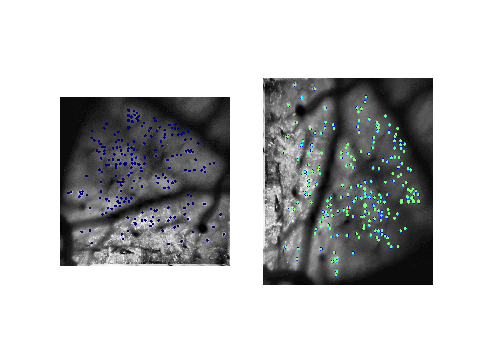

In [26]:
fig = pl.figure()
ax = fig.add_subplot(121)
plot_roi_overlay(roi_summed, roi_zproj_eq, ax=ax)


ax = fig.add_subplot(122)
plot_roi_overlay(roi_summed_transf, roi_zproj_transf, ax=ax)



In [25]:

#### Save
coreg_dir = os.path.split(coreg_dfile)[0]
alignment_outfile = os.path.join(coreg_dir, 'alignment_results.pkl')

'''
Saves:
    fov2p_transformed : 2p fov rotated, flipped, and pixel-scaled.
    fov2p_warped : 2p fov warped to align to widefield vasculature image with warp_mat.
    warp_mat : Transformation matrix to align 2p to widefield (wrap_im()).
    vasculature : Surface image (common to retino + 2p fov coreg.)
    
    
'''

class struct():
    pass
coreg_d = {'BV_transformed': coreg_fov2p_transformed,
           'BV_warped': coreg_fov2p_warped,
           'warp_mat': transform_mat,
           'vasculature': vasculature,
           'pixel_size': fov_.pixel_size}


# coreg_d = struct()
# coreg_d.transformed = coreg_fov2p_transformed
# coreg_d.warped = coreg_fov2p_warped

zproj_d = struct() #
zproj_d.original = roi_zproj
zproj_d.transformed = roi_zproj_transf
zproj_d.warped = roi_zproj_warped

rois_d = struct()
rois_d.original = roi_masks
rois_d.transformed = transf_rois
rois_d.warped = warped_rois


D = {'coreg': coreg_d,
    'zproj': zproj_d,
    'rois': rois_d}

with open(alignment_outfile, 'wb') as f:
    pkl.dump(D, f, protocol=pkl.HIGHEST_PROTOCOL)
    
    
# # outf = h5py.File(alignment_outfile, 'a')
# try:
#     #if fkey in outf.keys():
#     f = outf[fkey] if fkey in outf.keys() else outf.create_group(fkey)
#     #f = outf.create_group(fkey)

#     grp = f.create_dataset('coreg/fov2p_transformed', coreg_fov2p_transformed.shape, dtype=coreg_fov2p_transformed.dtype)
#     grp[...] = coreg_fov2p_transformed
#     grp = f.create_dataset('coreg/fov2p_warped', coreg_fov2p_warped.shape, dtype=coreg_fov2p_warped.dtype)
#     grp[...] = coreg_fov2p_warped
#     grp = f.create_dataset('coreg/warp_mat', transform_mat.shape, dtype=transform_mat.dtype)
#     grp[...] = transform_mat
#     grp = f.create_dataset('coreg/vasculature', vasculature.shape, dtype=vasculature.dtype)
#     grp[...] = vasculature
#     grp.attrs['fov2p_transformed'] = '2p fov rotated, flipped, and pixel-scaled'
#     grp.attrs['fov2p_warped'] = '2p fov warped to align to widefield vasculature image with warp_mat'
#     grp.attrs['warp_mat'] = 'Transformation matrix to align 2p to widefield (wrap_im())'
#     grp.attrs['source'] = coreg_dfile
#     grp.attrs['pixel_size'] = fov_.pixel_size


#     grp = f.create_dataset('zproj/image', roi_zproj.shape, dtype=roi_zproj.dtype)
#     grp[...] = roi_zproj
#     grp = f.create_dataset('zproj/transformed', roi_zproj_transf.shape, dtype=roi_zproj_transf.dtype)
#     grp[...] = roi_zproj_transf
#     grp = f.create_dataset('zproj/warped', roi_zproj_warped.shape, dtype=roi_zproj_warped.dtype)
#     grp[...] = roi_zproj_warped


#     grp = f.create_dataset('rois/masks', roi_masks.shape, dtype=roi_masks.dtype)
#     grp[...] = roi_masks
#     grp = f.create_dataset('rois/transformed', transf_rois.shape, dtype=transf_rois.dtype)
#     grp[...] = transf_rois
#     grp = f.create_dataset('rois/warped', warped_rois.shape, dtype=warped_rois.dtype)
#     grp[...] = warped_rois

#     grp.attrs['roiid'] = roi_id
#     grp.attrs['traceid'] = traceid
# except Exception as e:
#     traceback.print_exc()
# finally:
#     outf.close()


# np.savez(alignment_outfile, 
#          'coreg_transformed': fov2p_transformed,
#          'coreg_aligned': fov2p_to_widefield,
         
#          'roi_zproj': roi_zproj,
#          'roi_summed': roi_img,
#          'roi_masks': roi_masks,
         
#          'transform_mat': transform_mat,
         
#          )

In [ ]:
print(alignment_outfile)

<IPython.core.display.Javascript object>


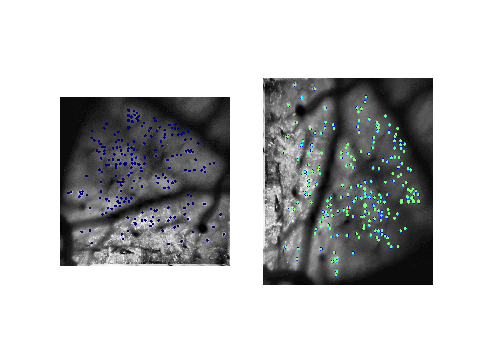

In [427]:
fig = pl.figure()
ax = fig.add_subplot(121)
plot_roi_overlay(roi_summed, roi_zproj_eq, ax=ax)


ax = fig.add_subplot(122)
plot_roi_overlay(roi_summed_transf, roi_zproj_transf, ax=ax)



In [404]:
 d1, d2, nrois = roi_masks.shape
    
transf_rois = [transform_2p_fov(roi_masks[:, :, i].astype(float), fov_.pixel_size) for i in np.arange(0, nrois)]

warped_rois = np.dstack([warp_im(tr_im, transform_mat, vasculature.shape) \
               for tr_im in transf_rois])
    

Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (512, 512)
Input img shape: (51

('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping...', 0, 255)
('warping..

## Plot all the steps

<IPython.core.display.Javascript object>


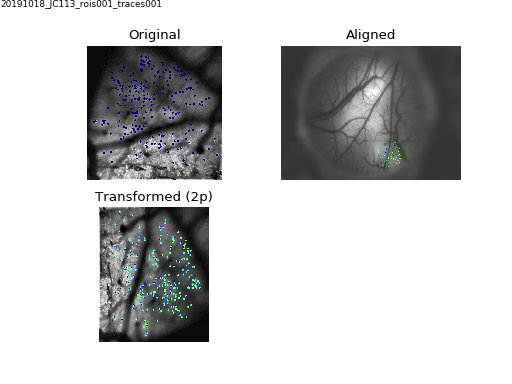

In [349]:
roi_img_aligned_overlay = np.ma.masked_where(roi_img_aligned == 0, roi_img_aligned)

fig = pl.figure() #constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2) #, figure=fig)

ax = fig.add_subplot(gs[0, 0])
plot_roi_overlay(roi_img, roi_zproj_eq, ax=ax)
ax.set_title('Original')

ax = fig.add_subplot(gs[1, 0])
plot_roi_overlay(roi_img_transf, roi_zproj_transf, ax=ax)
ax.set_title('Transformed (2p)')


ax = fig.add_subplot(gs[0, 1])
ax.imshow(vasculature, cmap='gray')
ax.imshow( roi_zproj_aligned, cmap='Greens', alpha=0.2)
ax.imshow( roi_img_aligned_overlay, cmap='jet', alpha=1.0)
ax.axis('off')
ax.set_title('Aligned')

putils.label_figure(fig, data_id)


#### Load area boundaries

In [222]:

borders_dfile = glob.glob(os.path.join(aggregate_dir, 'widefield-maps', 'signmaps',
                      'retinotopic-mapper', '%s_*' % animalid, '*%s_results.pkl' % animalid))[0]
with open(borders_dfile, 'rb') as f:
    retino = pkl.load(f)

ImportError: No module named retinotopic_mapping.RetinotopicMapping

In [141]:
callable(getattr(fov_, 'transform_anatomicals'))

True

In [132]:
dir(fov_)

['__doc__',
 '__init__',
 '__module__',
 'acquisition',
 'alignment',
 'animalid',
 'coreg_dir',
 'get_transformed_image',
 'image',
 'image_fpath',
 'image_path',
 'meta',
 'rootdir',
 'scale_anatomicals',
 'session',
 'transform_anatomicals']

In [142]:
f.close()

AttributeError: 'str' object has no attribute 'close'

In [89]:
# load anatomical (transformed)

def load_anatomical(animalid, session, fov, fmt='tif', channel_id=2, rootdir='/n/coxfs01/2p-data'):

    anat_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'anatomical', \
                                        'anatomical_Channel%02d*scaled.%s' % (channel_id, fmt)))[0]
    
    if fmt=='tif':
        img = tf.imread(anat_fpath)
    else:
        img = cv2.imread(anat_fpath)
        
    if len(img.shape)>2:
        img = img[:, :, 0]
    
    return img

<IPython.core.display.Javascript object>


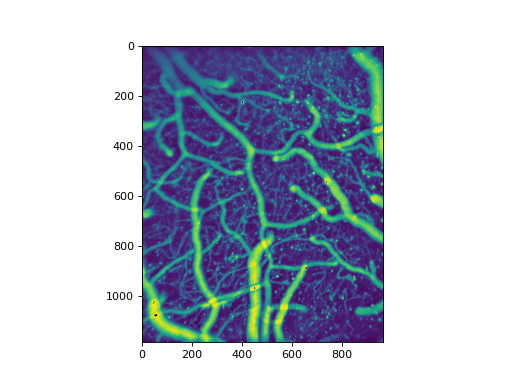

In [91]:
zimg = load_anatomical(animalid, session, fov, fmt=fmt)
pl.figure()
pl.imshow(zimg)

In [74]:
xaxis_conversion = 2.31 #2.312 # goes with A-P axis
yaxis_conversion = 1.89  #1.904 # goes with M-L axis

d1, d2 = img.shape # (im_h, im_w)
new_d1 = int(round(d1*xaxis_conversion, 1)) # after transform, 
new_d2 = int(round(d2*yaxis_conversion, 1)) # after transform, d2~ML axis (width), 
zimg_r = cv2.resize(im, (new_d2, new_d1))   # (new_d1~COLS, new_d2~ROWS)
print(zimg_r.shape)
print(new_d1, new_d2)

In [83]:
img.size

262144

<IPython.core.display.Javascript object>


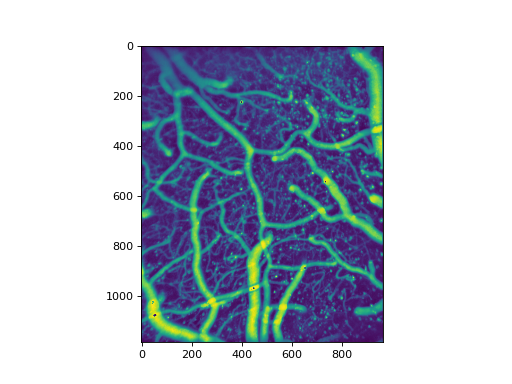

In [84]:
pl.figure()
pl.imshow(zimg_r)

In [60]:
img_outpath = '%s_scaled2.%s' % (os.path.splitext(anat_fpath)[0], fmt)

if fmt=='tif':
    tf.imsave(img_outpath, zimg_r)
else:
    cv2.imwrite(img_outpath, zimg_r)



True

In [63]:
tf.im

AttributeError: 'module' object has no attribute 'im'

In [ ]:
('saved results: ', '/n/coxfs01/julianarhee/aggregate-visual-areas/widefield-maps/signmaps/retinotopic-mapper/JC076_20190404/20190404_MJC076_results.pkl')